In [5]:
# Étape 1: Importation des bibliothèques nécessaires

# Importation des bibliothèques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate

# Étape 2: Chargement et exploration initiale des données

# Chargement des données
links_data = pd.read_csv("links.csv")
movies_data = pd.read_csv("movies.csv")
tags_data = pd.read_csv("tags.csv")
ratings_data = pd.read_csv("ratings.csv")

# Exploration initiale des données de films et d'évaluations
movies_head = movies_data.head()
ratings_head = ratings_data.head()

movies_head, ratings_head


(   movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931)

In [6]:
# Exploration initiale des données de films et d'évaluations

movies_head = movies_data.head()
ratings_head = ratings_data.head()

movies_head, ratings_head


(   movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931)

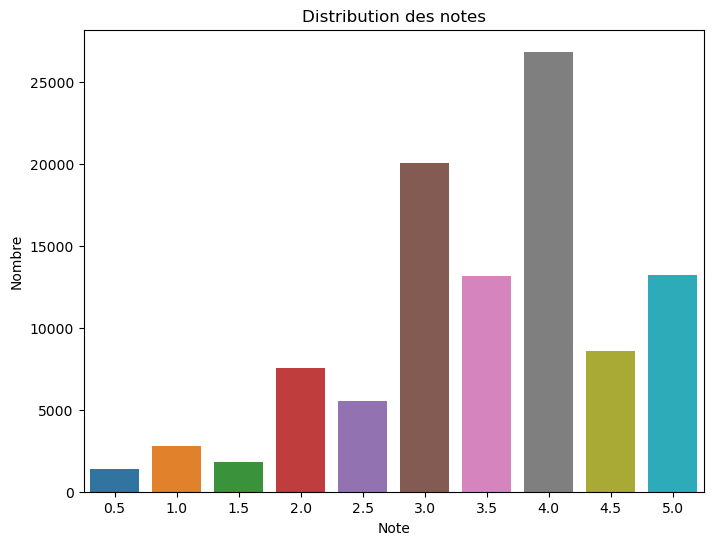

(9742, 610, 165.30491803278687, 10.369806663924312)

In [7]:
# Étape 3: Analyse Exploratoire des Données (EDA)

# Visualisation de la distribution des notes
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings_data)
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Nombre')
plt.show()

# Nombre total de films et d'utilisateurs
num_movies = movies_data['movieId'].nunique()
num_users = ratings_data['userId'].nunique()

# Nombre moyen de notes par utilisateur et par film
avg_ratings_per_user = ratings_data.groupby('userId').size().mean()
avg_ratings_per_movie = ratings_data.groupby('movieId').size().mean()

num_movies, num_users, avg_ratings_per_user, avg_ratings_per_movie


In [8]:
# Étape 4: Préparation des données pour le système de recommandation

# Création de la matrice utilisateur-film
user_movie_matrix = ratings_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Normalisation des notes par utilisateur (soustraction de la note moyenne de chaque utilisateur)
user_ratings_mean = user_movie_matrix.mean(axis=1)
user_movie_matrix_normalized = user_movie_matrix.sub(user_ratings_mean, axis=0)

# Conversion des DataFrames en matrices numpy pour des calculs plus rapides
matrix_user_movie = user_movie_matrix_normalized.values
user_ratings_mean = user_ratings_mean.values.reshape(-1, 1)

# Vérification de la taille de la matrice utilisateur-film
matrix_user_movie.shape


(610, 9724)

In [9]:
# Étape 5: Construction du système de recommandation

from scipy.sparse.linalg import svds

# Application de la Singular Value Decomposition (SVD)
U, sigma, Vt = svds(matrix_user_movie, k=50)  # k est le nombre de facteurs latents

# Conversion de sigma en une matrice diagonale
sigma = np.diag(sigma)

# Prédiction des notes pour chaque utilisateur et film en utilisant les matrices décomposées
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_movie_matrix.columns)

# Vérification des premières lignes de la matrice des notes prédites
predicted_ratings_df.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


In [12]:
# Étape 6: Évaluation et tests

def recommend_movies(user_id, num_recommendations=5):
    """
    Recommande des films pour un utilisateur donné.
    
    Arguments:
    - user_id : ID de l'utilisateur.
    - num_recommendations : Nombre de recommandations à retourner.

    Retourne:
    - DataFrame contenant les recommandations.
    """
    
    # Récupération des films que l'utilisateur a déjà notés
    user_rated_movies = ratings_data[ratings_data['userId'] == user_id]['movieId'].tolist()
    
    # Récupération des notes prédites pour cet utilisateur
    user_predictions = predicted_ratings_df.iloc[user_id - 1].drop(user_rated_movies).sort_values(ascending=False)
    
    # Récupération des films les mieux notés que l'utilisateur n'a pas encore vus
    recommended_movies = movies_data[movies_data['movieId'].isin(user_predictions.head(num_recommendations).index)]
    
    return recommended_movies

# Test de la fonction pour un utilisateur (par exemple, l'utilisateur 5)
recommendations_for_user_5 = recommend_movies(5, 10)  # 10 recommandations pour l'utilisateur 5
recommendations_for_user_5


,movieId,title,genres
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
134,161,Crimson Tide (1995),Drama|Thriller|War
138,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
334,377,Speed (1994),Action|Romance|Thriller
395,454,"Firm, The (1993)",Drama|Thriller
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
436,500,Mrs. Doubtfire (1993),Comedy|Drama
472,539,Sleepless in Seattle (1993),Comedy|Drama|Romance
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller


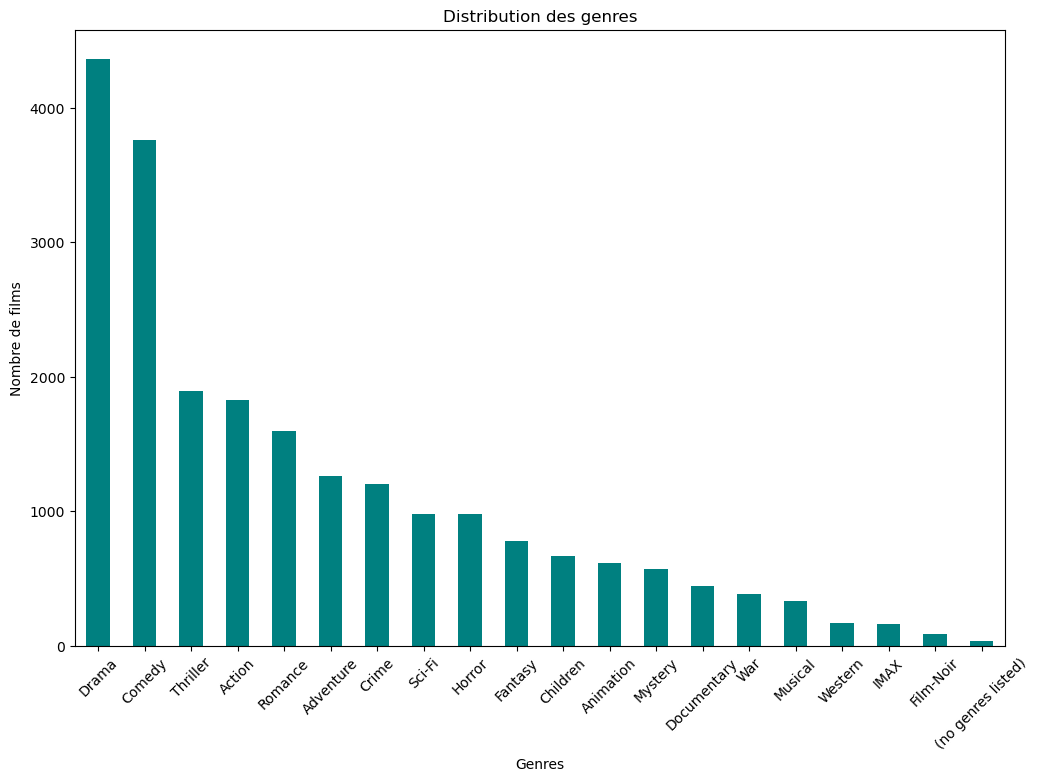

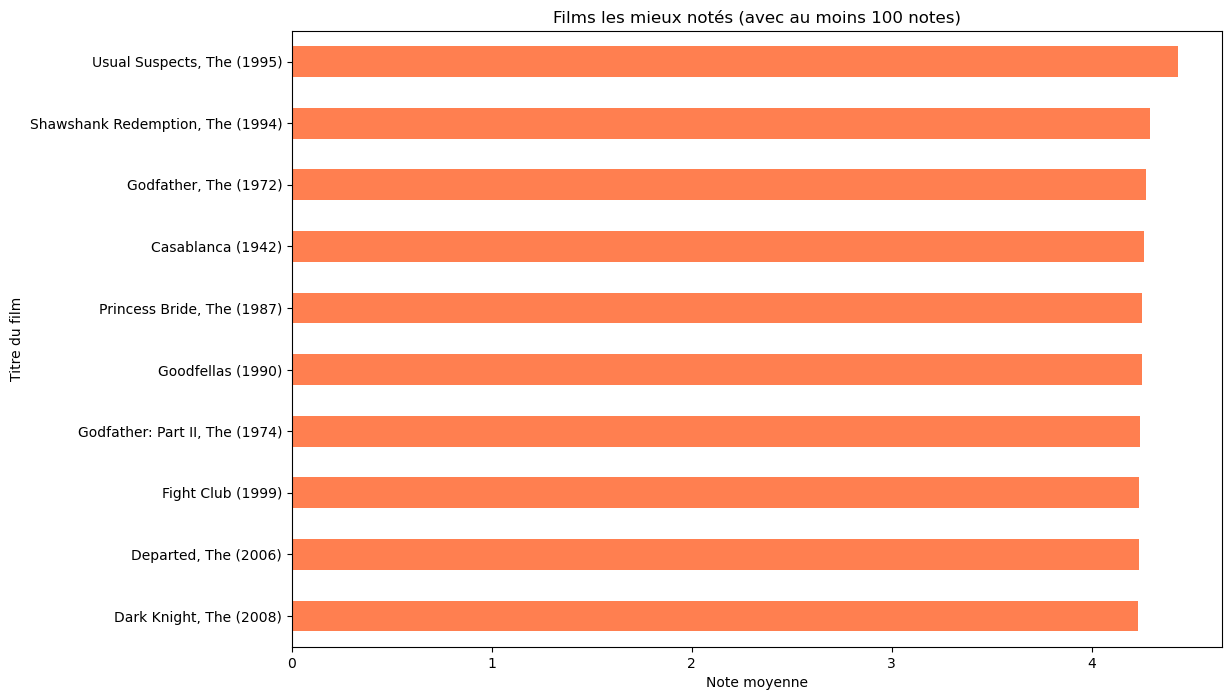

In [13]:
# Étape 7: Visualisation des résultats

# Distribution des genres
all_genres = movies_data['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 8))
all_genres.plot(kind='bar', color='teal')
plt.title('Distribution des genres')
plt.xlabel('Genres')
plt.ylabel('Nombre de films')
plt.xticks(rotation=45)
plt.show()

# Films les mieux notés (avec au moins 100 notes)
movie_avg_ratings = ratings_data.groupby('movieId')['rating'].mean()
movie_num_ratings = ratings_data.groupby('movieId').size()
popular_movies = movie_avg_ratings[movie_num_ratings >= 100].sort_values(ascending=False).head(10)
popular_movies_titles = movies_data[movies_data['movieId'].isin(popular_movies.index)]['title'].tolist()
plt.figure(figsize=(12, 8))
popular_movies.plot(kind='barh', color='coral')
plt.title('Films les mieux notés (avec au moins 100 notes)')
plt.xlabel('Note moyenne')
plt.ylabel('Titre du film')
plt.yticks(ticks=range(10), labels=popular_movies_titles)
plt.gca().invert_yaxis()  # Pour afficher le film le mieux noté en haut
plt.show()
